In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from random import random,gauss,seed,sample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

scaler = StandardScaler()

In [4]:
# Function that creates descriptive variables of the time series:
# Mean of the 5 past values
# Maximum and minimum of 5 past values
# The difference with value at time t
def df_outliers(df):
    dfplot2 = df[['date','value']].reset_index(drop=True)
    dfplot2['pct_change'] = df.value.pct_change()

    for i in dfplot2.index[5:]:
        dfplot2.loc[i,'mean_5_past_values'] = np.mean(
            [dfplot2.loc[i-1,'value'],dfplot2.loc[i-2,'value'],dfplot2.loc[i-3,'value'],
             dfplot2.loc[i-4,'value'],dfplot2.loc[i-5,'value']])

    for i in dfplot2.index[5:]:
        dfplot2.loc[i,'max_5_past_values'] = max(
            [dfplot2.loc[i-1,'value'],dfplot2.loc[i-2,'value'],dfplot2.loc[i-3,'value'],
             dfplot2.loc[i-4,'value'],dfplot2.loc[i-5,'value']])

    for i in dfplot2.index[5:]:
        dfplot2.loc[i,'min_5_past_values'] = min(
            [dfplot2.loc[i-1,'value'],dfplot2.loc[i-2,'value'],dfplot2.loc[i-3,'value'],
             dfplot2.loc[i-4,'value'],dfplot2.loc[i-5,'value']])

    dfplot2['dif_mean'] = abs(dfplot2.value-dfplot2.mean_5_past_values)
    dfplot2['dif_max'] = abs(dfplot2.value-dfplot2.max_5_past_values)
    dfplot2['dif_min'] = abs(dfplot2.value-dfplot2.min_5_past_values)
    dfplot2 = dfplot2.dropna()
    return dfplot2
    
# Function that plots the outliers:
# We first resume each observation to two components with a PCA fitting
# We apply a DBSCAN clustering algorithm to find outliers based on the two components
# We plot the two components and the difference in means of each variable between the clusters
# We plot the time series along with the outliers found
def plot_outliers(dfmodel):
    dfpca = pd.DataFrame(PCA(n_components=2).fit_transform(
            dfmodel.drop(['date'],1)))
    dfpca.columns = ['pc1','pc2']

    dbs = DBSCAN(min_samples=20,eps=.5).fit(scaler.fit_transform(dfpca))
    res = dfmodel.copy()
    res['cluster'] = dbs.labels_
    res['Status'] = np.where(res.cluster == -1,'outlier','normal')
    dfpca['cluster'] = dbs.labels_
    dfpca['color'] = np.where(dfpca.cluster == -1,'red','blue')

    plt.figure(figsize=(20,5))

    plt.subplot(121)
    plt.scatter(dfpca.pc1,dfpca.pc2,color=dfpca.color)
    plt.xlabel('Principal component 1',fontsize=15)
    plt.ylabel('Principal component 2',fontsize=15)
    plt.title('DBSCAN clustering',fontsize=20)

    plt.subplot(122)
    means = res.drop(['date','cluster'],1).groupby('Status').mean().diff().dropna()
    x = means.columns
    y = means.iloc[0,:].values
    plt.bar(x,y,color='blue')
    plt.title('Diference in means between cluster',fontsize = 20)
    plt.xticks(rotation=45)
    
    plt.show()

    dfmodel['cluster'] = dbs.labels_
    plt.figure(figsize=(20,5))
    plt.plot(dfmodel.date,dfmodel.value,color='blue')
    plt.scatter(dfmodel.loc[dfmodel.cluster==-1].date,
                dfmodel.loc[dfmodel.cluster==-1].value,
                color='red',label='outliers')
    plt.legend()
    plt.title('Time Series outliers',fontsize=20)
    plt.show()

# Time series visualization

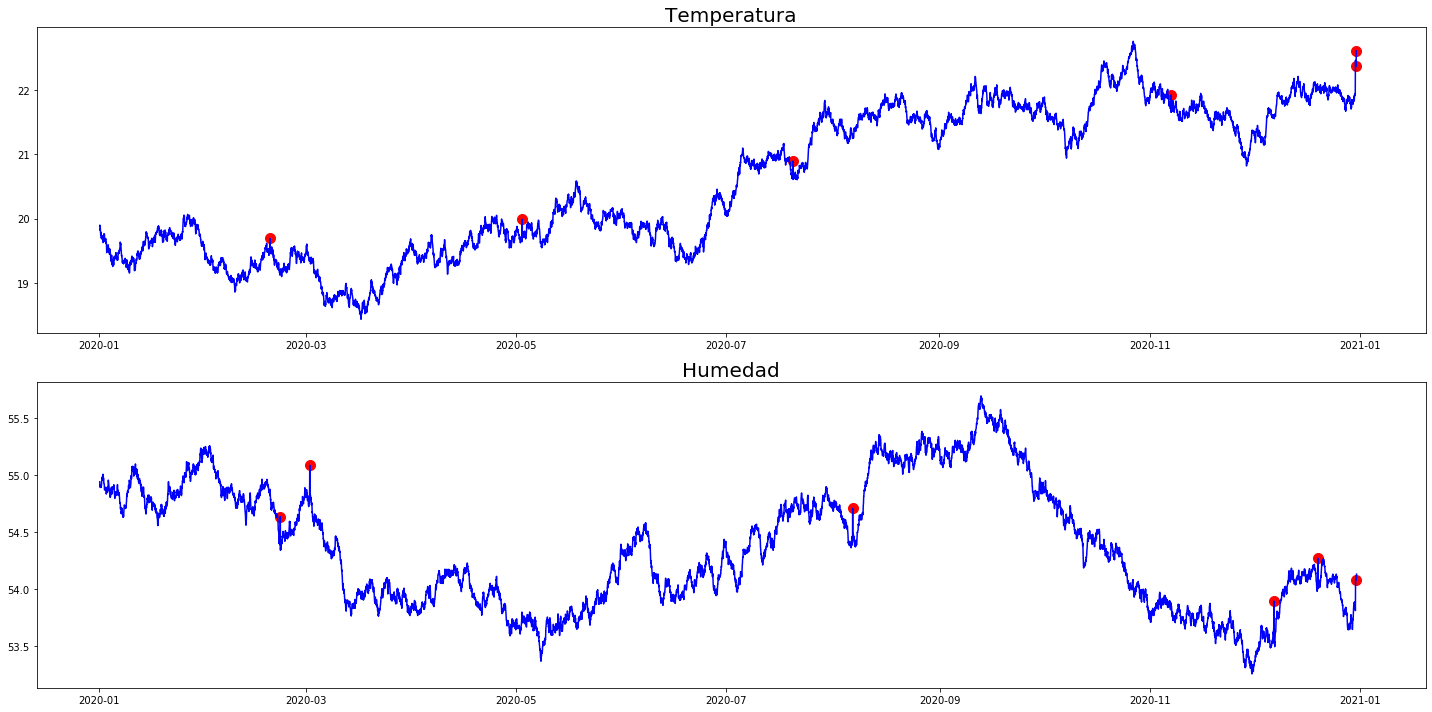

In [14]:
temp = pd.read_csv('../Data/ts_temperature.csv').drop('Unnamed: 0',1)
hu = pd.read_csv('../Data/ts_humidity.csv').drop('Unnamed: 0',1)

temp.date = pd.to_datetime(temp.date)
hu.date = pd.to_datetime(hu.date)

# Añadimos 5 outliers
indexes_temp = sample(temp.index.tolist(),5)
for i in indexes_temp:
    temp.loc[i:i,'value'] = temp.loc[i:i,'value']+0.25
    
indexes_hu = sample(hu.index.tolist(),5)
for i in indexes_hu:
    hu.loc[i:i,'value'] = hu.loc[i:i,'value']+0.25

# Grafico series de tiempo
plt.figure(figsize=(20,10))

# Temperatura
plt.subplot(211)
plt.plot(temp.date,temp.value,color='blue')
plt.scatter(temp.loc[indexes_temp,'date'],temp.loc[indexes_temp,'value'],color='red',s=100)
plt.scatter(temp.loc[temp.shape[0]-3,'date'],temp.loc[temp.shape[0]-3,'value'],color='red',s=100)
plt.title('Temperatura',fontsize=20)

# Humedad
plt.subplot(212)
plt.plot(hu.date,hu.value,color='blue')
plt.scatter(hu.loc[indexes_hu,'date'],hu.loc[indexes_hu,'value'],color='red',s=100)
plt.scatter(hu.loc[hu.shape[0]-3,'date'],hu.loc[hu.shape[0]-3,'value'],color='red',s=100)
plt.title('Humedad',fontsize=20)

plt.tight_layout()
plt.show()

# Temperature

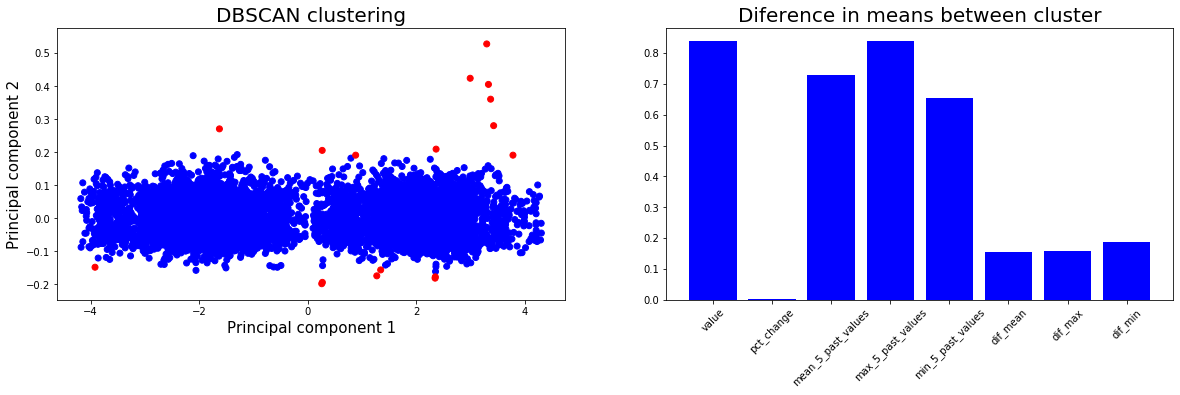

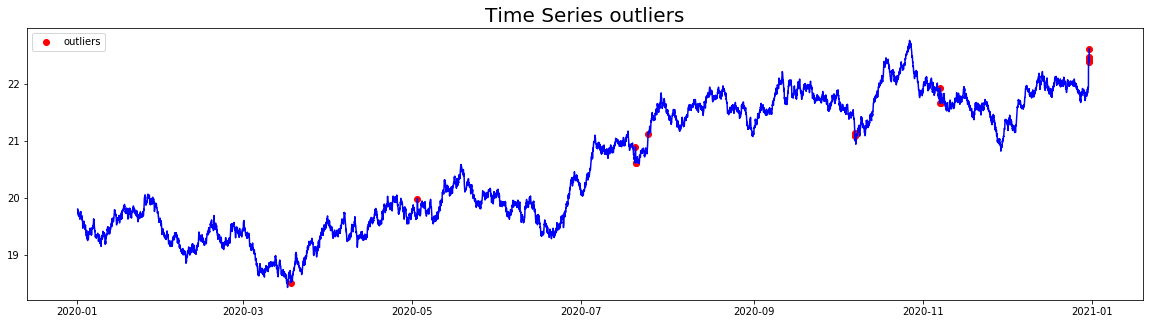

In [16]:
dfmodel = df_outliers(temp)
plot_outliers(dfmodel)

# Humidity

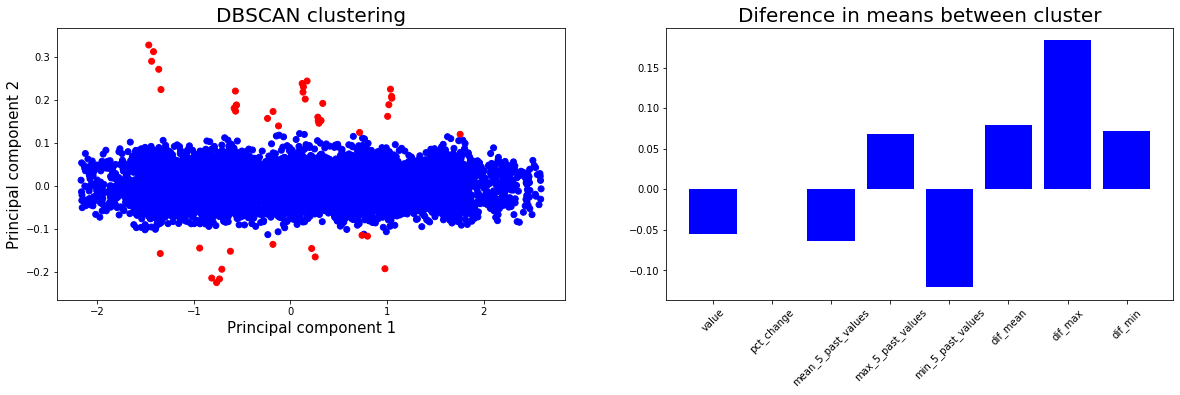

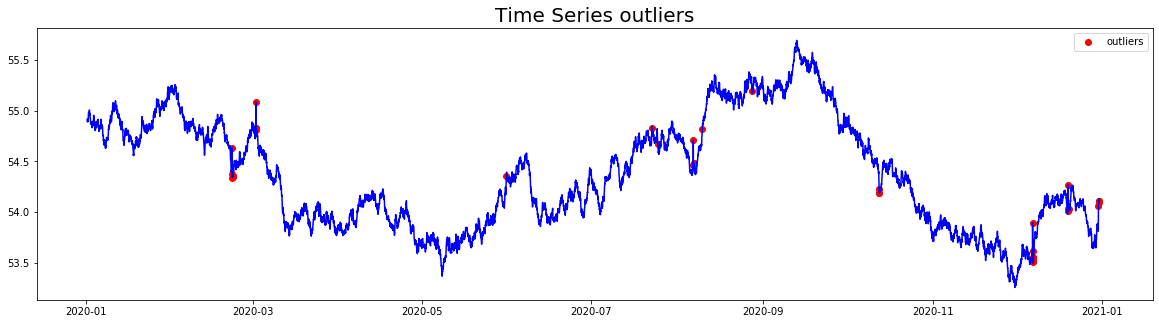

In [17]:
dfmodel = df_outliers(hu)
plot_outliers(dfmodel)